### Install needs

In [104]:
# pip install biopython bio networkx

### Imports

In [172]:
from collections import defaultdict
from grammar.pcfg import PCFG
from itertools import product
from scipy.linalg import expm
import matplotlib.pyplot as plt
from Bio import Phylo
import networkx as nx
import numpy as np

### Stockholm to Phylip format conversion
https://www.hiv.lanl.gov/content/sequence/FORMAT_CONVERSION/form.html

### Get Maximum Likelihood phylogenetic tree
http://www.atgc-montpellier.fr/phyml/

### Get From files

##### Sequences

In [106]:
def read_sequences (filename: str):
    first_ln = False
    num_seq = 0
    len_seq = 0
    
    seq_dict = defaultdict(str)
    
    with open(filename) as file:
        for line in file:
            line = line.strip().split()
            if len(line) == 2:
                if first_ln == False:
                    num_seq = int(line[0])
                    len_seq = int(line[1])
                    first_ln = True
                else:
                    if len(line[1]) == len_seq and num_seq != 0:
                        seq_dict[line[0]] = line[1]
                        num_seq -= 1
                    else: 
                        raise ValueError("Invalid file structure")
    return seq_dict

##### Tree

In [107]:
def clade_names_fix(tree):
    for index, clade in enumerate(tree.find_clades()):
        if not clade.name:
            if index == 0:
                clade.name = "root"
            else:
                clade.name = str(index)

def read_tree(filename: str):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    return Phylo.to_networkx(Tree)

##### Structure

In [108]:
def read_structure(filename: str):
    with open(filename) as file:
        return file.readline().strip()

In [109]:
def simplify_struct(structure: str, filename=""):
    pairing_chars = ["<", ">", "(", ")", "[", "]", "{", "}"]
    simplified = ""
    for i in range(len(structure)):
        if structure[i] in pairing_chars:
            simplified += "d "
        else:
            simplified += "s "
    if filename != "":        
        with open(f"{filename}.train", "w+") as file:
            file.write(simplified)
    
    return simplified

### Validate Sequence String

In [110]:
def is_valid_str(input_string, valid_characters):
    for char in input_string:
        if char not in valid_characters:
            return False
    return True

### Get Pairing Charecter

In [111]:
def get_pair_start(pair_end):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return [val for val in pairing_chars if val[1] == pair_end][0][0]

In [112]:
def is_pair_start(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[0] for p in pairing_chars]

In [113]:
def is_pair_end(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[1] for p in pairing_chars]

### Calculate frequency

In [114]:
def calc_frequencies (seq_dict: defaultdict, structure, known_chars = ["A", "C", "G", "U", "-"]):
    single_nucleotides = defaultdict(int)
    paired_nucleotides = defaultdict(int)
    
    total_singles = 0
    total_paireds = 0
    
    # Stack of unpaired nucleotides (structure symbol, nocleotide)
    unpaired_nucleotides = []
    
    for _, sequence in seq_dict.items():
        for index, nucleotide in enumerate(sequence): 
            structure_symbol = structure[index]
            # Having a charecter [ '(', '[', '{', '<' ]
            if is_pair_start(structure_symbol):
                unpaired_nucleotides.append((structure_symbol, nucleotide))
            # Having a charecter [ ')', ']', '}', '>' ]
            elif is_pair_end(structure_symbol):
                unpaired_nucleotide = unpaired_nucleotides.pop()
                if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                    paired_nucleotide = unpaired_nucleotide[1] + nucleotide
                    if is_valid_str(paired_nucleotide, known_chars):
                        paired_nucleotides[paired_nucleotide] += 1
                        paired_nucleotides[paired_nucleotide[::-1]] += 1
                        total_paireds += 1
                    else:
                        raise ValueError('Invalid charecter in sequence')
                else:
                    raise ValueError('Invalid pattern in structure')
            # Having a non-pairing charecter
            else:
                if is_valid_str(nucleotide, known_chars):
                    single_nucleotides[nucleotide] += 1
                    total_singles += 1
                else: 
                    raise ValueError('Invalid charecter in sequence')

    
    total = total_singles + total_paireds
                
    for key, value in single_nucleotides.items():
        single_nucleotides[key] = value / total_singles
    for key, value in paired_nucleotides.items():
        paired_nucleotides[key] = value / total_paireds
        
    return single_nucleotides, paired_nucleotides, total_singles / total, total_paireds / total

### Find time two sequences

In [115]:
def find_node_by_name(graph, name_str):
    return [node for _, node in enumerate(list(graph.nodes)) if node.name==name_str][0]

In [116]:
def calculate_time(graph, sourceName, targetName):
    source_node = find_node_by_name(graph, sourceName)
    target_node = find_node_by_name(graph, targetName)
    
    return nx.shortest_path_length(
            graph, 
            source= source_node, 
            target= target_node, 
            weight= "weight"
        )

### Simularity Percentage

In [117]:
def check_simularity(seq1:str, seq2:str):
    simularity = 0
    if len(seq1) == len(seq2):
        for i in range(len(seq1)):
            if seq1[i] == seq2[i]:
                simularity += 1
        return simularity / len(seq1) >= .85

### Calculate Rate Matrix
$$r_{XY}=\frac{c_{XY}}{2p_xP_s\sum_{P} N_Pt_P}$$

In [118]:
def calc_rate_values(
    graph, 
    seq_dict: defaultdict, 
    structure, 
    single_frequencies, 
    paired_frequencies, 
    singles_prob, 
    paireds_prob, 
    legal_chars = ["A", "C", "G", "U", "-"]
):
    seq_list = [(k, v) for k, v in seq_dict.items()]
    tp_sumation = 0
    unpaired_nucleotides = []
    
    single_mutation_count = defaultdict(float)
    paired_mutation_count = defaultdict(float)
    
    for i in range(len(seq_list)):
        temp_single_mutation_count = defaultdict(int)
        temp_paired_mutation_count = defaultdict(int)
        
        same_first_sequence_count = 0
        
        for j in range(len(seq_list)):
            first_name = seq_list[i][0]
            first_sequence = seq_list[i][1]
            second_name = seq_list[j][0]
            second_sequence = seq_list[j][1]
            # The pair should contain diffrent 
            # sequence with at least %85 simularity.
            if i != j and check_simularity(first_sequence, second_sequence):
                same_first_sequence_count += 1
                for k in range(len(first_sequence)): 
                    structure_symbol = structure[k]
                    # Having a charecter [ '(', '[', '{', '<' ]
                    if is_pair_start(structure_symbol):
                        unpaired_nucleotides.append((
                            structure_symbol, 
                            first_sequence[k], 
                            second_sequence[k]
                        ))
                    # Having a charecter [ ')', ']', '}', '>' ]
                    elif is_pair_end(structure_symbol):
                        unpaired_nucleotide = unpaired_nucleotides.pop()
                        first_pair = unpaired_nucleotide[1] + first_sequence[k]
                        second_pair = unpaired_nucleotide[2] + second_sequence[k]
                        if first_pair != second_pair:
                            if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                                if (is_valid_str(first_pair, legal_chars) 
                                and is_valid_str(second_pair, legal_chars)):
                                    temp_paired_mutation_count[(first_pair, second_pair)] += 1
                                    temp_paired_mutation_count[(first_pair[::-1], second_pair[::-1])] += 1
                                else:
                                    raise ValueError('Invalid charecter in sequence')
                            else:
                                raise ValueError('Invalid pattern in structure')    
                    # Having a non-pairing charecter
                    else:
                        if first_sequence[k] != second_sequence[k]:
                            if (is_valid_str(first_sequence[k], legal_chars) 
                            and is_valid_str(second_sequence[k], legal_chars)):
                                temp_single_mutation_count[(
                                    first_sequence[k], 
                                    second_sequence[k],
                                )] += 1
                tp_sumation += calculate_time(graph, first_name, second_name)
        
        if same_first_sequence_count > 0:
            for key in temp_single_mutation_count:
                single_mutation_count[key] += (temp_single_mutation_count[key] 
                                               / same_first_sequence_count)
            for key in temp_paired_mutation_count:
                paired_mutation_count[key] += (temp_paired_mutation_count[key] 
                                               / same_first_sequence_count)
                
    single_chars = legal_chars
    paired_chars = [c1 + c2 for c1 in single_chars for c2 in single_chars]
    
    single_rate_values = defaultdict(float)
    paired_rate_values = defaultdict(float)
    
    k = tp_sumation * len(structure)
            
    for i in single_chars:
        single_rate_values[(i,i)] = 0
        for j in single_chars:
            if i != j:
                single_rate_values[(i,j)] = (single_mutation_count[(i,j)] 
                                             / (singles_prob * single_frequencies[i] * k))
                single_rate_values[(i,i)] = single_rate_values[(i,i)] - single_rate_values[(i,j)]

    for i in paired_chars:
        paired_rate_values[(i,i)] = 0
        for j in paired_chars:
            if i != j:
                paired_rate_values[(i,j)] = (paired_mutation_count[(i,j)] 
                                             / (paireds_prob * paired_frequencies[i] * k))
                paired_rate_values[(i,i)] = paired_rate_values[(i,i)] - paired_rate_values[(i,j)]
    
    return single_rate_values, paired_rate_values  

### Probablity matrix From Q matrix

$$P = e^{Qt}$$

In [119]:
def get_probablity_values(mutation_rate_values, time, order_array = ["A", "C", "G", "U", "-"]):
    mutation_rate_matrix = np.zeros((len(order_array), len(order_array)), np.float64)
    
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            mutation_rate_matrix[i_index,j_index] = mutation_rate_values[(i_value, j_value)]
    
    probablity_rate_matrix = expm(mutation_rate_matrix * time)
    
    probablity_rate_values = defaultdict(float)
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            probablity_rate_values[(i_value, j_value)] = probablity_rate_matrix[i_index,j_index]
    
    return probablity_rate_values

### Get subtree from leavs

In [120]:
def get_subtree(graph, leavs_name):
    subtree_nodes = []
    leaf_nodes = []
    unleaf_nodes = []
    
    for i in range(len(leavs_name)):
        first_node = find_node_by_name(graph, leavs_name[i])
        subtree_nodes.append(first_node)
        leaf_nodes.append(first_node)
        for j in range(i+1, len(leavs_name)):
            second_node = find_node_by_name(graph, leavs_name[j])
            
            path = nx.shortest_path(
                graph, 
                first_node, 
                second_node
            )

            for node in path:
                if not node in subtree_nodes:
                    subtree_nodes.append(node)
                    if not node.name in leavs_name:
                        unleaf_nodes.append(node)              
    
    subtree = graph.subgraph(subtree_nodes)
    
    subtree_root = None
    min_distance = float("inf")
    
    graph_root = find_node_by_name(graph, "root")
    
    for node in subtree.nodes:
        new_distance = nx.shortest_path_length(
            graph, 
            node,
            graph_root, 
        )
        if new_distance < min_distance:
            min_distance = new_distance
            subtree_root = node
            
    nx.draw(subtree, with_labels=True)
        
    return subtree, subtree_root, leaf_nodes, unleaf_nodes

### Generate all occurrence

In [121]:
def get_all_occurrence(height, is_paired=False):
    single = ['A', 'C', 'G', 'U', '-']
    paired = [c1 + c2 for c1 in single for c2 in single]
    
    if is_paired == False:
        return [p for p in product(single, repeat = height)]
    else:
        return [p for p in product(paired, repeat = height)]
        

### Sort nodes on edge

In [122]:
def sort_nodes_on_edge(graph, edge, root):
    if nx.shortest_path_length(
        graph, 
        source= edge[0],
        target= root, 
    ) < nx.shortest_path_length(
        graph, 
        source= edge[1],
        target= root, 
    ) :
        return edge[0], edge[1]
    return edge[1], edge[0]

### Get column probablity

In [123]:
def calc_column_prob(
    subtree, 
    subtree_root, 
    leaf_nodes, 
    unleaf_nodes, 
    frequencies, 
    rate_values, 
    leaf_values, 
    is_paired=False
):
    column_probablity = 0
        
    unleaf_values_list = get_all_occurrence(len(unleaf_nodes), is_paired)
    for unleaf_values in unleaf_values_list:
        temp = 1
        for edge in subtree.edges():
            down_value = None
            up_node, down_node = sort_nodes_on_edge(subtree, edge, subtree_root)
            
            if down_node in leaf_nodes:
                down_value = leaf_values[leaf_nodes.index(down_node)]
            else:
                down_value = unleaf_values[unleaf_nodes.index(down_node)]
            up_value = unleaf_values[unleaf_nodes.index(up_node)]
            
            time = nx.shortest_path_length(
                subtree,
                up_node,
                down_node,
                "weight"
            )
            single_bases = ['A', 'C', 'G', 'U', '-']
            paired_bases = [c1 + c2 for c1 in single_bases for c2 in single_bases]
            if is_paired:
                probablity_values = get_probablity_values(rate_values, time, paired_bases)
            else:
                probablity_values = get_probablity_values(rate_values, time, single_bases)
            temp *= probablity_values[(up_value, down_value)]
                
        root_value = None
        if subtree_root in leaf_nodes:
            root_value = leaf_values[leaf_nodes.index(subtree_root)]
        else:
            root_value = unleaf_values[unleaf_nodes.index(subtree_root)]
        
        column_probablity += (temp * frequencies[root_value])
        
    return column_probablity

In [124]:
def get_column_probs(
    subtree, 
    subtree_root, 
    leaf_nodes, 
    unleaf_nodes, 
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values, 
    aligned_list
):
    single_column_probs = defaultdict(float)
    paired_column_probs = defaultdict(float)
    single_leaf_values_list = get_all_occurrence(len(aligned_list), is_paired=False)
    paired_leaf_values_list = get_all_occurrence(len(aligned_list), is_paired=True)
    
    for leaf_values in single_leaf_values_list:
        single_column_probs[tuple(leaf_values)] = calc_column_prob(
        subtree, 
        subtree_root, 
        leaf_nodes, 
        unleaf_nodes, 
        single_frequencies, 
        single_rate_values, 
        leaf_values,
        is_paired=False
    )
    
    for leaf_values in paired_leaf_values_list:
        paired_column_probs[tuple(leaf_values)] = calc_column_prob(
        subtree, 
        subtree_root, 
        leaf_nodes, 
        unleaf_nodes, 
        paired_frequencies, 
        paired_rate_values, 
        leaf_values,
        is_paired=True
    )
    
    return single_column_probs, paired_column_probs

### Estimate PCFG on structure 

In [125]:
# Train for first time
# pcfg = PCFG("Structure.cfg")
# pcfg.estimate("RF03000.train", iter_num=20)

In [126]:
# Read from trained file
pcfg = PCFG("Structure.cfg", "Structure.pcfg")

defaultdict(<class 'float'>, {('S', 'L', 'S'): 0.9213480439012321, ('S', 'Dm', 'Dr'): 0.017930477456403877, ('F', 'Dm', 'Dr'): 0.8171596601964021, ('F', 'L', 'S'): 0.18284033980359785, ('L', 'Dm', 'Dr'): 0.05248219336729697, ('Dm', 'Dl', 'F'): 1.0, ('S', 's'): 0.060721478642363845, ('L', 's'): 0.9475178066327031, ('Dl', 'd'): 1.0, ('Dr', 'd'): 1.0})


In [127]:
unary_rules = pcfg.grammar.unary_rules
binary_rules = pcfg.grammar.binary_rules

for A, B, C in binary_rules:
    print(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}")
    
for A, w in unary_rules:
    print(f"{A} -> {w} {pcfg.q[(A, w)]}")

S -> L S 0.9213480439012321
S -> Dm Dr 0.017930477456403877
F -> Dm Dr 0.8171596601964021
F -> L S 0.18284033980359785
L -> Dm Dr 0.05248219336729697
Dm -> Dl F 1.0
S -> s 0.060721478642363845
L -> s 0.9475178066327031
Dl -> d 1.0
Dr -> d 1.0


### Get CYK tree

In [128]:
def gen_parse_tree(tree, table, start, end, non_terminal = "S", firstRun = True, layer=1):
    if firstRun:
        tree.add_node((start, end, "S"), layer=layer)
        layer += 1
    for _start, _end, _non_terminal in table[(start, end, non_terminal)]:
        tree.add_node((_start, _end, _non_terminal), layer=layer)
        new_layer = layer + 1
        tree.add_edge((_start, _end, _non_terminal), (start, end, non_terminal))
        gen_parse_tree(tree, table, _start, _end, _non_terminal, firstRun=False, layer=new_layer)

In [188]:
def draw_parse_tree(table, start_point, end_point):
    parse_tree = nx.Graph()
    
    gen_parse_tree(parse_tree, table, start_point, end_point)
    
    pos = nx.multipartite_layout(parse_tree, subset_key ="layer")
    nx.draw(
        parse_tree, 
        pos, 
        with_labels=True, 
        node_color='lightblue', 
        node_size=5, 
        font_size=.0001
    )
    nx.draw_networkx_nodes(
        parse_tree, 
        pos, 
        nodelist=[(start_point, end_point, "S")], 
        node_color='green', 
        node_size=5
    )

### Extend grammar

In [140]:
def extend_grammar(
    unary_rules, 
    binary_rules, 
    single_column_probs, 
    paired_column_probs,
    filename="Extended"
):
    with (open(f"{filename}.pcfg", "w+") as pcfg_file, open(f"{filename}.cfg", "w+") as cfg_file):
        for A, B, C in binary_rules:
            if A == "Dm" and B == "Dl" and C == "F":
                for column, prob in single_column_probs.items():
                    term = str(column).replace(" ", "")
                    pcfg_file.write(f"{A+term} -> Dl{term} F {pcfg.q[(A, B, C)]}" + "\n")
                    cfg_file.write(f"{A+term} -> Dl{term} F" + "\n")
            elif B == "Dm" and C == "Dr":
                for column, prob in paired_column_probs.items():
                    left = str(tuple(
                        pair[0] for pair in column if pair
                    )).replace(" ", "")
                    right = str(tuple(
                        pair[1] for pair in column if pair
                    )).replace(" ", "")
                    pcfg_file.write(f"{A} -> Dm{left} Dr{right} {pcfg.q[(A, B, C)] * prob}" + "\n")
                    cfg_file.write(f"{A} -> Dm{left} Dr{right}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}" + "\n")
                cfg_file.write(f"{A} -> {B} {C}" + "\n")

        for A, w in unary_rules:
            if w == "s":
                for column, prob in single_column_probs.items():
                    term = str(column).replace(" ", "")
                    pcfg_file.write(f"{A} -> {term} {pcfg.q[(A, w)] * prob}" + "\n")
                    cfg_file.write(f"{A} -> {term}" + "\n")
            elif w == "d":
                for column, prob in single_column_probs.items():
                    term = str(column).replace(" ", "")
                    pcfg_file.write(f"{A+term} -> {term} {pcfg.q[(A, w)]}" + "\n")
                    cfg_file.write(f"{A+term} -> {term}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}" + "\n")
                cfg_file.write(f"{A} -> {w}" + "\n")

### Get total sequence

In [153]:
def get_total_sequence(seq_dict, aligned_list):
    total_sequence = ""
    for i in range(len(seq_dict[aligned_list[0]])):
        column = tuple([
            seq_dict[seq_name][i] for seq_name in aligned_list
        ])
        total_sequence += str(column).replace(" ", "") + " "
    return total_sequence

# Test

### Calculate mutation rate and frequencies

In [130]:
structure = read_structure("RF03000.structure")
seq_dict = read_sequences("RF03000.phylip")
graph = read_tree("RF03000.nwk")
simplified = simplify_struct(structure, "RF03000")

(single_frequencies, 
 paired_frequencies, 
 singles_prob, 
 paireds_prob) = calc_frequencies(seq_dict, structure)

(single_rate_values, 
 paired_rate_values) = calc_rate_values(
    graph, 
    seq_dict, 
    structure, 
    single_frequencies, 
    paired_frequencies, 
    singles_prob, 
    paireds_prob
)

### Calculat probablities

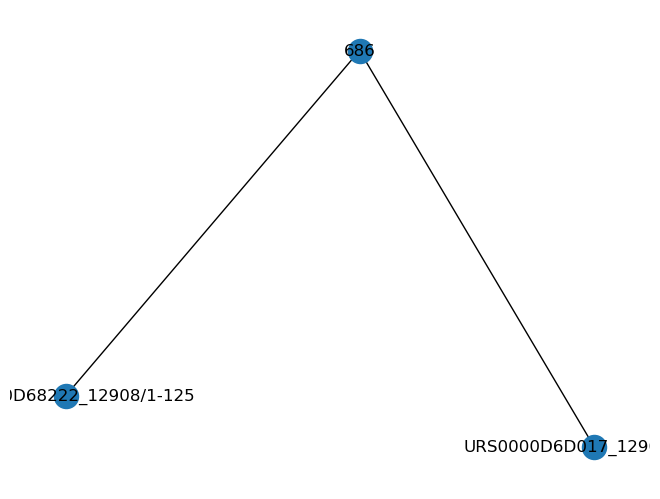

In [131]:
aligned_list = ["URS0000D68222_12908/1-125", "URS0000D6D017_12908/1-124"]
subtree, subtree_root, leaf_nodes, unleaf_nodes = get_subtree(graph, aligned_list)

(single_column_probs,
 paired_column_probs) = get_column_probs(
    subtree, 
    subtree_root, 
    leaf_nodes, 
    unleaf_nodes, 
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values, 
    aligned_list
)

In [141]:
unary_rules = pcfg.grammar.unary_rules
binary_rules = pcfg.grammar.binary_rules

extend_grammar(
    unary_rules, 
    binary_rules, 
    single_column_probs, 
    paired_column_probs,
)

In [142]:
# Read from extended file
extended_pcfg = PCFG("Extended.cfg", "Extended.pcfg")

defaultdict(<class 'float'>, {('S', 'L', 'S'): 0.9213480439012321, ('S', "Dm('A','A')", "Dr('A','A')"): 0.0003779309931445702, ('S', "Dm('A','A')", "Dr('A','C')"): 5.194328927266245e-07, ('S', "Dm('A','A')", "Dr('A','G')"): 4.750969501362165e-10, ('S', "Dm('A','A')", "Dr('A','U')"): 1.958120933415751e-06, ('S', "Dm('A','A')", "Dr('A','-')"): 2.53297872458041e-06, ('S', "Dm('A','C')", "Dr('A','A')"): 5.194328927266245e-07, ('S', "Dm('A','C')", "Dr('A','C')"): 1.3374645840777558e-09, ('S', "Dm('A','C')", "Dr('A','G')"): 6.465659696768935e-07, ('S', "Dm('A','C')", "Dr('A','U')"): 6.464421558935118e-10, ('S', "Dm('A','C')", "Dr('A','-')"): 2.477309374575221e-09, ('S', "Dm('A','G')", "Dr('A','A')"): 4.750969501362164e-10, ('S', "Dm('A','G')", "Dr('A','C')"): 6.465659696768933e-07, ('S', "Dm('A','G')", "Dr('A','G')"): 2.030835753064168e-11, ('S', "Dm('A','G')", "Dr('A','U')"): 6.28107956862092e-09, ('S', "Dm('A','G')", "Dr('A','-')"): 6.605723473961222e-08, ('S', "Dm('A','U')", "Dr('A','A')"

In [176]:
total_sequence = get_total_sequence(seq_dict, aligned_list)
_, table = pcfg.sentence_prob(total_sequence)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Ali Ahmadi\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Ali Ahmadi\AppData\Local\Temp\ipykernel_16276\727564034.py", line 1, in <module>
    _, table = pcfg.sentence_prob(total_sequence)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ali Ahmadi\Desktop\RNA Secondary Structure Prediction\notebook\grammar\pcfg.py", line -1, in sentence_prob
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Ali Ahmadi\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ali Ahmadi\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return For

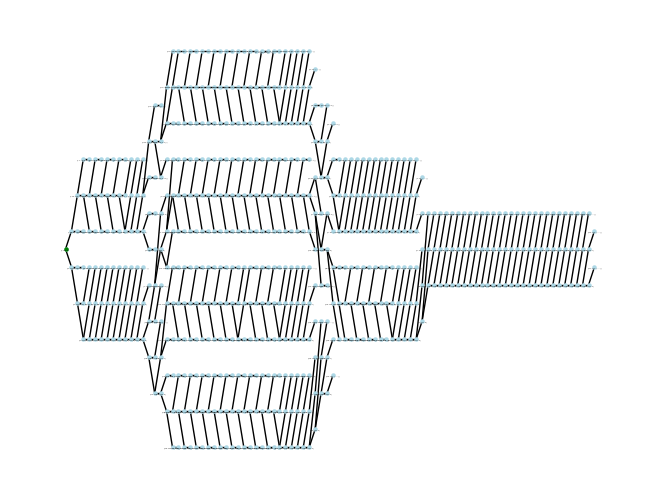

In [189]:
draw_parse_tree(table, 1, len(seq_dict[aligned_list[0]]))
plt.savefig("plot.png", dpi=1000)

In [187]:
table

defaultdict(None,
            {(1, 1, 'S'): [(1, 1, "('A','A')")],
             (1, 1, "('A','A')"): [],
             (1, 1, 'L'): [(1, 1, "('A','A')")],
             (1, 1, "Dl('A','A')"): [(1, 1, "('A','A')")],
             (1, 1, "Dr('A','A')"): [(1, 1, "('A','A')")],
             (2, 2, 'S'): [(2, 2, "('G','G')")],
             (2, 2, "('G','G')"): [],
             (2, 2, 'L'): [(2, 2, "('G','G')")],
             (2, 2, "Dl('G','G')"): [(2, 2, "('G','G')")],
             (2, 2, "Dr('G','G')"): [(2, 2, "('G','G')")],
             (3, 3, 'S'): [(3, 3, "('C','C')")],
             (3, 3, "('C','C')"): [],
             (3, 3, 'L'): [(3, 3, "('C','C')")],
             (3, 3, "Dl('C','C')"): [(3, 3, "('C','C')")],
             (3, 3, "Dr('C','C')"): [(3, 3, "('C','C')")],
             (4, 4, 'S'): [(4, 4, "('C','C')")],
             (4, 4, "('C','C')"): [],
             (4, 4, 'L'): [(4, 4, "('C','C')")],
             (4, 4, "Dl('C','C')"): [(4, 4, "('C','C')")],
             (4, 4, "Dr('